## Pytorch Transfer Learning

In [1]:
import torch
import torchvision

In [2]:
print(torch.__version__)
print(torchvision.__version__)

2.2.2
0.17.2


In [3]:
import torchinfo

In [4]:
# setup device agnostic code
device = "cuda" if torch.cuda.is_available else "cpu"

In [5]:
from going_modular import data_setup, engine

### 1. Get Data
We need our pizza, steak, sushi dataset to build a transfer learning model

In [6]:
import os

from pathlib import Path

# setup data path
data_path = Path("/Users/venu/Documents/Productivity/Pytorch Tutorials/data")
image_path = Path(data_path / "pizza_steak_sushi")

In [7]:
# setup directory path for train and test dataset
train_dir = image_path / "train"
test_dir = image_path / "test"

In [8]:
test_dir, test_dir

(PosixPath('/Users/venu/Documents/Productivity/Pytorch Tutorials/data/pizza_steak_sushi/test'),
 PosixPath('/Users/venu/Documents/Productivity/Pytorch Tutorials/data/pizza_steak_sushi/test'))

## 2. Create Datasets and DataLoaders

1. Now we have some data to transform into Pytorch DataLoaders.
2. We can use our already created pytorch script `script.py` -> `create_dataloaders()` function.
3. We need to think about how we **transform** our data when loading a pretrained model.
4. 1. Manually created transforms - where we manually create data_transform defining what our data wants to go through.
   2. Automatically created transforms - the **transforms** of your data are defined by the **pre-trained** model which you choose to use.
5. **Important Note** - When we use a pretrained model, it is important that the data(including our custom data) that we use is **transformed** in the same way that the data the **pre-trained** model was trained on

#### Creating a Transform for `torchvision.models` (auto creation)

In [9]:
import torchvision

In [10]:
# Get the set of pre-trained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT #default = best available weights

In [11]:
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [12]:
# Now we use the model transform used to created our pretrained weights
# Instead of manually creating transforms, we can use the models weights and 
#use the transforms of that model which are used to craete those weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [13]:
# Create dataloaders using auto_transforms
train_dataloader, test_dataloader, class_names = data_setup.create_dataloader(train_dir= train_dir,
                                                                             test_dir = test_dir,
                                                                             batch_size=32,
                                                                             transform=auto_transforms,
                                                                             num_workers=0)

In [14]:
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x153ae41d0>,
 ['pizza', 'steak', 'sushi'])

### 3. Which Pretrained model should you choose?
Three things to consider - 
1. Speed
2. Size
3. Performance

We can choose the model which balances all the above three arguments for better real world use case

### Importing and setting-up a pretrained model (EffNetB0)

In [15]:
model = torchvision.models.efficientnet_b0(weights = weights)

In [16]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [17]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

EfficientNet contains 3 important parts - 
1. Features - Ectracts features from the Image
2. Avgpool - Turns features into a single feature vector by taking the average of features
3. Classifier - Classifier turns feature vector into prediction logits, the out_features in classifier is adjustable depending on the number of classes we have

We keep the weights frozen in transfer learning

#### Getting Summary of our model with `torchinfo.summary()`

In [18]:
from torchinfo import summary

In [19]:
summary(model = model,
       input_size=[1, 3, 224, 224], #[batch, color channels, height, width],
       col_names = ["input_size", "output_size", "num_params", "trainable"],
       col_width = 20,
       row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

1. Here we want to freeze the base layers and use the default weights.
2. We only want to update the classifier out_features to make it suitable for own problem

### Freezing the base model and changing the classifier layer to suit the requirements of our model

In [25]:
# Freeze all of the base layers in the model
for param in model.features.parameters():
    param.requires_grad = False

In [26]:
summary(model = model,
       input_size=[1, 3, 224, 224], #[batch, color channels, height, width],
       col_names = ["input_size", "output_size", "num_params", "trainable"],
       col_width = 20,
       row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [28]:
# Update the classifier head of the model to suit our labels length
model.classifier
# dropout is used to avoid overfitting of the model, p is the probability you give

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [31]:
from torch import nn
torch.manual_seed(95)


model.classifier = nn.Sequential(
    nn.Dropout(p = 0.2, inplace = True),
    nn.Linear(in_features=1280, out_features=len(class_names)))# infeatures is the feature vector coming in

In [32]:
summary(model = model,
       input_size=[1, 3, 224, 224], #[batch, color channels, height, width],
       col_names = ["input_size", "output_size", "num_params", "trainable"],
       col_width = 20,
       row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

### 4. Training the Mode

In [33]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(),
                            lr = 0.01)

In [39]:
# Import train function
from going_modular import engine
from timeit import default_timer as timer

# setup the manual seed
torch.manual_seed(95)

# start the timer
start_timer = timer()

# setup training of the model and save the results
model_results = engine.train(model = model,
                            train_dataloader= train_dataloader,
                            test_dataloader= test_dataloader,
                            optimizer= optimizer,
                            loss_fn= loss_fn,
                            epochs= 10,
                            device = "cpu")

end_timer = timer()
print(f"Total Training Time: {end_timer - start_timer:.3f}seconds.")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0528 | train_acc: 0.9883 | test_loss: 1.1859 | test_acc: 0.6203
Epoch: 2 | train_loss: 0.3803 | train_acc: 0.8438 | test_loss: 0.2954 | test_acc: 0.8665
Epoch: 3 | train_loss: 0.3823 | train_acc: 0.8672 | test_loss: 0.3420 | test_acc: 0.8655
Epoch: 4 | train_loss: 0.2440 | train_acc: 0.8594 | test_loss: 0.7651 | test_acc: 0.7225
Epoch: 5 | train_loss: 0.0910 | train_acc: 0.9766 | test_loss: 0.3487 | test_acc: 0.8769
Epoch: 6 | train_loss: 0.3617 | train_acc: 0.8477 | test_loss: 0.3255 | test_acc: 0.8968
Epoch: 7 | train_loss: 0.6973 | train_acc: 0.8438 | test_loss: 0.6148 | test_acc: 0.7330
Epoch: 8 | train_loss: 0.3626 | train_acc: 0.8203 | test_loss: 0.3504 | test_acc: 0.8456
Epoch: 9 | train_loss: 0.7351 | train_acc: 0.7656 | test_loss: 0.5908 | test_acc: 0.7841
Epoch: 10 | train_loss: 1.1180 | train_acc: 0.8555 | test_loss: 0.7218 | test_acc: 0.7225
Total Training Time: 143.658seconds.


In [40]:
model_results

{'train_loss': [0.05276302946731448,
  0.3803171193867456,
  0.3822818733751774,
  0.24404900707304478,
  0.09104586881585419,
  0.36171570722945035,
  0.6972853478509933,
  0.3626106050796807,
  0.7351269559003413,
  1.1180372859816998],
 'train_acc': [0.98828125,
  0.84375,
  0.8671875,
  0.859375,
  0.9765625,
  0.84765625,
  0.84375,
  0.8203125,
  0.765625,
  0.85546875],
 'test_loss': [1.1858607580264409,
  0.29535431663195294,
  0.3420253296693166,
  0.7651368876298269,
  0.3486677209536235,
  0.325501615802447,
  0.6147555112838745,
  0.35044190287590027,
  0.5908163785934448,
  0.7217618227005005],
 'test_acc': [0.6202651515151515,
  0.8664772727272728,
  0.8655303030303031,
  0.7225378787878788,
  0.8768939393939394,
  0.8967803030303031,
  0.7329545454545454,
  0.8456439393939394,
  0.7840909090909092,
  0.7225378787878788]}

## 5. Evaluate the model by plotting some loss curves

In [42]:
try:
    from helper_functions import plot_loss_curves
except:
    print(f"COuld not find helper_funtion imported. Downloading ---")
    with open("helper_function.py", "wb") as f:
        import requests
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/helper_functions.py")
        f.write(request.content)
    print("Imported Helper Function")
    from helper_functions import plot_loss_curves

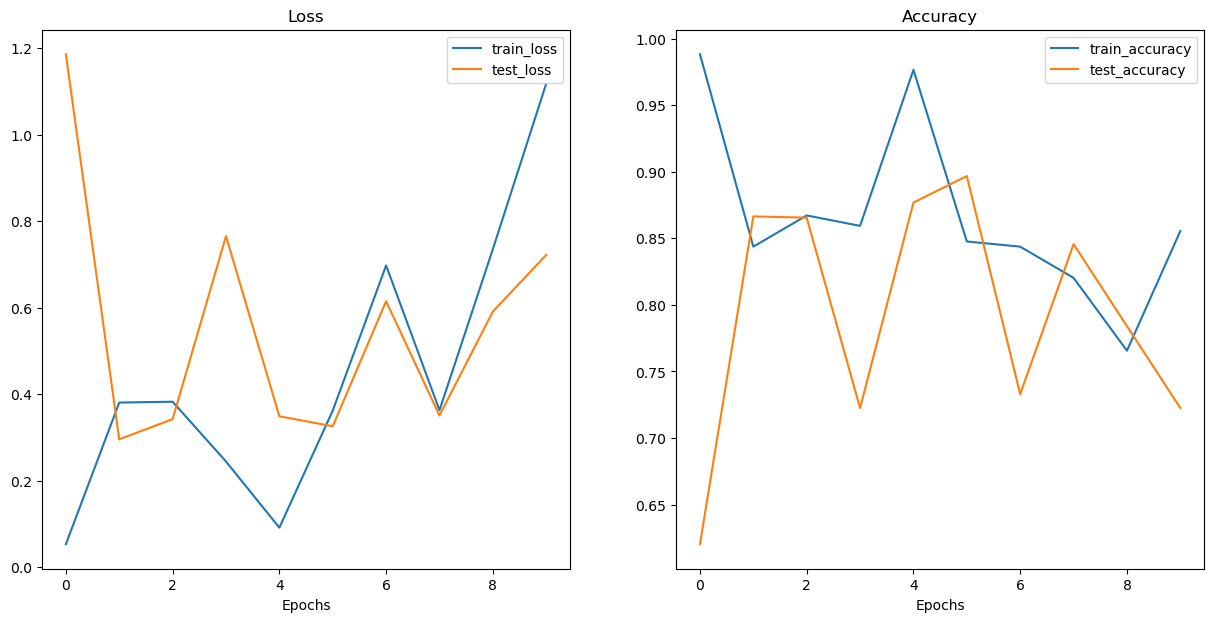

In [43]:
plot_loss_curves(model_results)

### Make predictions on custom images or from test images

Things to consider while making predictions on custom dataset or test dataset --

1. Same Shape - Images need to be in the same shape as the model is trained on.
2. Same datatype - Images need to be of the same datatype
3. Sama device - custom dataset need to be on the same device as the model
4. Same Transform - The custom data or the test data should go through the same transform as the trained data

#### To achieve the above steps we can create a function which can perform all the above steps -
`https://www.learnpytorch.io/04_pytorch_custom_datasets/#113-putting-custom-image-prediction-together-building-a-function`

The function needs to perform the following  -
1. Take in the trained_model, list of class names, path of the target image, image size, transform for the target image and target device.
2. Open the image using `PIL.Image.Open()`
3. Create a transform if one does not exist, the image should go through the transform
4. Make sure the model is on the target device
5. Turn the eval mode of the mode, this will turn off the back prop and make the model ready for inferencing.
6. Transform the target image and make sure the dimensionality of the target image is suited for the model.
7. Make a prediction on the target image by passing the image to the model
8. Convert the output logits of the model into prediction_probs using `torch.softmax()`
9. Convert the prediction_probs into prediction labels using `torch.argmax()`
10. Plot the image using matplotlib and set the title of the plot to the prediction label

In [78]:
from typing import List, Tuple
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

# 1. create a function to take in the model and other required args
def predict_and_plot_image(model: torch.nn.Module,
                          class_names: List[str],
                          image_path: str,
                          transform: torchvision.transforms = None,
                          image_size: Tuple[int, int] = (224, 224),
                           device: torch.device = "cpu"
):
    #2. open the image using PIL
    target_image = Image.open(image_path)

    #3. create a transform for the target image
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([transforms.Resize(image_size),
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])]
                                            )

    #4. Make sure the model is on the target device
    model.to(device)

    ### Prediction on the target Image

    #5. Put the model in eval mode 
    model.eval()
    with torch.inference_mode():
        #6. Transform the target image and add an extra dimension for batch size ->[B,c,H,W]
        transformed_image = image_transform(target_image).unsqueeze(dim = 0)

        #7. Make prediction on the transformed image and also ensuring its on the target device
        pred_logits = model(transformed_image).to(device)

    #8. Converting the logits into prediction probs
    pred_probs = torch.softmax(pred_logits, dim = 1)

    #9. Converitng the prediction probs into prediction labels
    pred_label = torch.argmax(pred_probs, dim = 1)

    #10. Plot the target image by titling the label with the predicted class name
    plt.figure()
    plt.imshow(target_image)
    plt.title(f"Predicted Class: {class_names[pred_label]},  with Probability {pred_probs.max():.3f}")
    plt.axis(False);
    

### Predicting on the target image

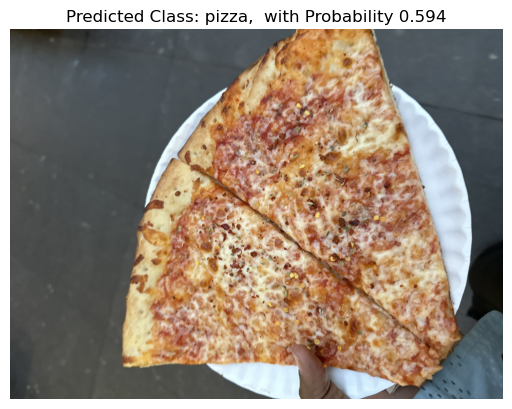

In [79]:
predict_and_plot_image(model = model,
                      class_names=class_names,
                      image_path="/Users/venu/Documents/Productivity/Pytorch Tutorials/data/pizza_steak_sushi/IMG_4406.JPG")

#### Predicting on the test dir images

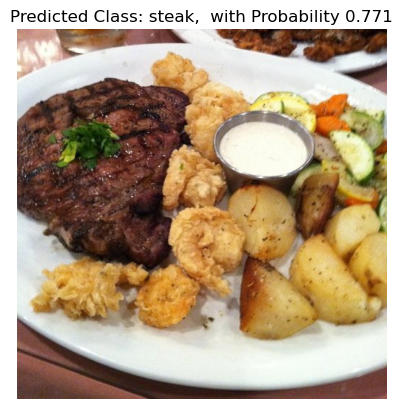

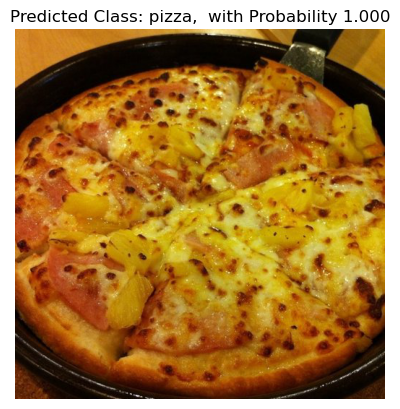

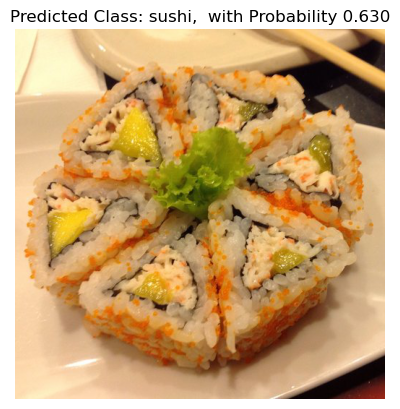

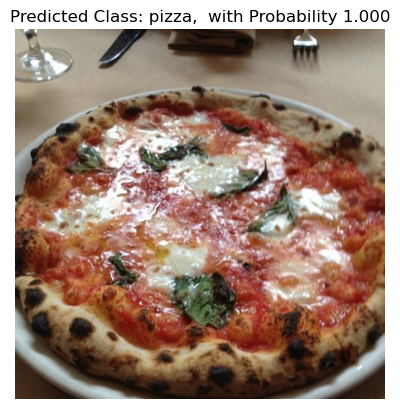

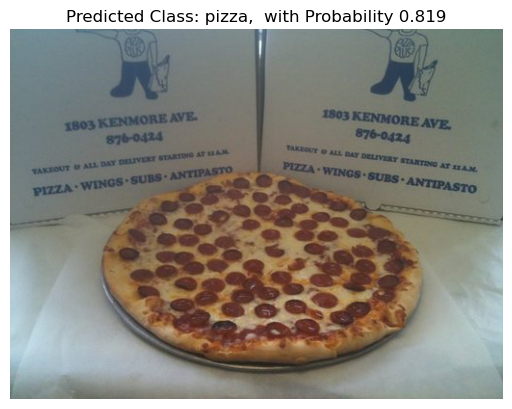

In [83]:
import random

num_of_images_to_predict = 5
test_image_paths = list(Path(test_dir).glob("*/*.jpg"))
#print(len(test_image_paths))
test_image_samples = random.sample(population = test_image_paths,
                                  k  =num_of_images_to_predict)

# Make prediction on the test_image_samples
for test_image_path in test_image_samples:
    
    predict_and_plot_image(model = model,
                          class_names= class_names,
                          image_path=test_image_path)